In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [4]:
import os
import random
import shutil
import zipfile
import pandas as pd
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

# Paths
ZIP_PATH = "/content/archive.zip"
EXTRACT_PATH = "/content/dataset"

# Extract zip if not already done
if not os.path.exists(EXTRACT_PATH):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

# Class folders
SHIP_DIR = os.path.join(EXTRACT_PATH, "ship")
NO_SHIP_DIR = os.path.join(EXTRACT_PATH, "no-ship")

# Collect all image paths and labels
all_images = []
for img in os.listdir(SHIP_DIR):
    all_images.append((os.path.join(SHIP_DIR, img), "ship"))
for img in os.listdir(NO_SHIP_DIR):
    all_images.append((os.path.join(NO_SHIP_DIR, img), "no-ship"))

# Create DataFrame
df = pd.DataFrame(all_images, columns=["filepath", "label"])

# Train/Val/Test split
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Create YOLO classification folders
for split in ["train", "val", "test"]:
    for class_name in ["ship", "no-ship"]:
        os.makedirs(f"/content/yolo_data/{split}/{class_name}", exist_ok=True)

# Move images into correct folders
def process_split(df, split):
    for _, row in df.iterrows():
        class_name = row["label"]
        dest_dir = os.path.join("/content/yolo_data", split, class_name)
        shutil.copy(row["filepath"], os.path.join(dest_dir, os.path.basename(row["filepath"])))

process_split(train_df, "train")
process_split(val_df, "val")
process_split(test_df, "test")

# Train YOLOv8 classification model
# regular train
model1 = YOLO("yolov8n-cls.pt")
metrics1 = model1.train(data="/content/yolo_data", epochs=5, imgsz=640)

# train with frozen weights
model2 = YOLO("yolov8n-cls.pt")

# Freezing the first layers
for name, param in model2.model.named_parameters():
    if "backbone" in name:
        param.requires_grad = False

metrics2 = model2.train(data="/content/yolo_data", epochs=5, imgsz=640)



Extracting dataset...


100%|██████████| 5.31M/5.31M [00:00<00:00, 66.1MB/s]


Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, prof

train: Scanning /content/yolo_data/train... 3200 images, 0 corrupt: 100%|██████████| 3200/3200 [00:00<00:00, 5175.04it/s]

train: New cache created: /content/yolo_data/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 462.0±207.1 MB/s, size: 11.4 KB)



val: Scanning /content/yolo_data/val... 400 images, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 6448.98it/s]

val: New cache created: /content/yolo_data/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size



        1/5         0G     0.6741         16        640:   0%|          | 1/200 [00:10<34:15, 10.33s/it]


100%|██████████| 755k/755k [00:00<00:00, 12.9MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:08<00:00,  5.28s/it]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:02<00:00,  4.82s/it]

                   all      0.882          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:03<00:00,  4.92s/it]

                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:04<00:00,  4.95s/it]

                   all      0.965          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:06<00:00,  5.09s/it]

                   all      0.973          1

5 epochs completed in 2.007 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB


Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_data/train... found 3200 images in 2 classes ✅ 
val: /content/yolo_data/val... found 400 images in 2 classes ✅ 
test: /content/yolo_data/test... found 400 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:56<00:00,  4.38s/it]


                   all      0.973          1
Speed: 0.0ms preprocess, 122.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, nam

train: Scanning /content/yolo_data/train... 3200 images, 0 corrupt: 100%|██████████| 3200/3200 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 432.7±213.0 MB/s, size: 11.4 KB)



val: Scanning /content/yolo_data/val... 400 images, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train2
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:03<00:00,  4.91s/it]

                   all      0.938          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:07<00:00,  5.17s/it]

                   all      0.882          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:07<00:00,  5.18s/it]

                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:03<00:00,  4.86s/it]

                   all      0.965          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [01:03<00:00,  4.92s/it]

                   all      0.973          1

5 epochs completed in 2.163 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB


Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_data/train... found 3200 images in 2 classes ✅ 
val: /content/yolo_data/val... found 400 images in 2 classes ✅ 
test: /content/yolo_data/test... found 400 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:53<00:00,  4.12s/it]


                   all      0.973          1
Speed: 0.0ms preprocess, 114.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


Normal training accuracy: 0.9725
Frozen weights training accuracy: 0.9725


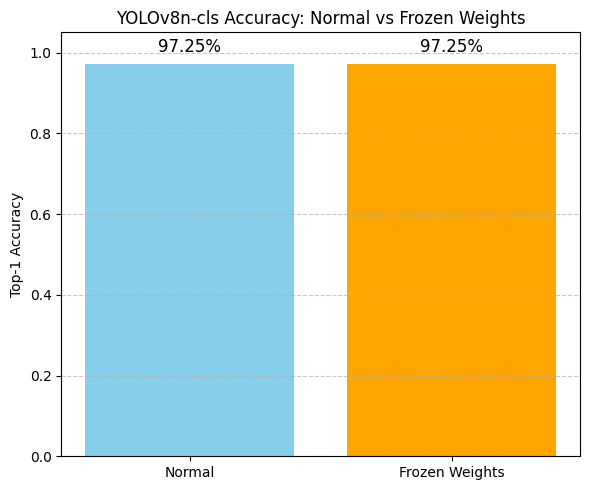

In [12]:
import matplotlib.pyplot as plt

# Extract Top-1 Accuracy values
acc_normal = metrics1.top1
acc_frozen = metrics2.top1

# Print values for confirmation
print(f"Normal training accuracy: {acc_normal:.4f}")
print(f"Frozen weights training accuracy: {acc_frozen:.4f}")

# Prepare labels and values
labels = ["Normal", "Frozen Weights"]
accuracies = [acc_normal, acc_frozen]

# Create bar chart
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, accuracies, color=["skyblue", "orange"])

# Annotate with percentage values
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f"{acc * 100:.2f}%", ha="center", va="bottom", fontsize=12)

# Add labels and title
plt.ylabel("Top-1 Accuracy")
plt.title("YOLOv8n-cls Accuracy: Normal vs Frozen Weights")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


🔍 Predicting on 400 test images...


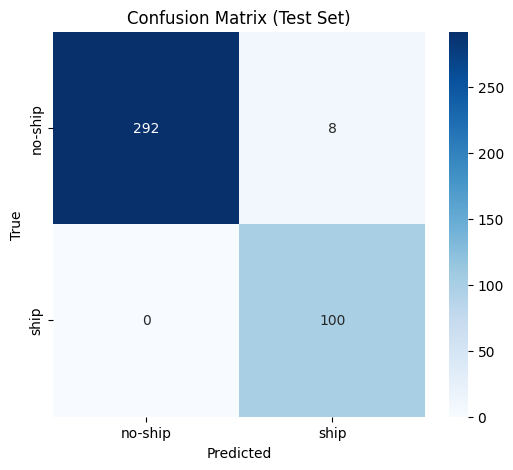

Classification Report (Test Set):

              precision    recall  f1-score   support

     no-ship       1.00      0.97      0.99       300
        ship       0.93      1.00      0.96       100

    accuracy                           0.98       400
   macro avg       0.96      0.99      0.97       400
weighted avg       0.98      0.98      0.98       400

Test Set Accuracy: 98.00%


In [11]:
import os
import glob
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- STEP 1: Get all test images and true labels ---
test_image_paths = glob.glob("/content/yolo_data/test/*/*.png")  # or .png
true_labels = [path.split("/")[-2] for path in test_image_paths]  # folder name is label

# Map class names to indices
class_names = sorted(list(set(true_labels)))
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# --- STEP 2: Run predictions on all test images ---
predicted_labels = []

print(f"🔍 Predicting on {len(test_image_paths)} test images...")

for path in test_image_paths:
    result = model1.predict(path, verbose=False)[0]
    pred_class = result.names[result.probs.top1]
    predicted_labels.append(pred_class)

# --- STEP 3: Evaluate ---
true_indices = [class_to_idx[label] for label in true_labels]
predicted_indices = [class_to_idx[label] for label in predicted_labels]

# Confusion Matrix
cm = confusion_matrix(true_indices, predicted_indices)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Classification Report
report = classification_report(true_indices, predicted_indices, target_names=class_names)
print("Classification Report (Test Set):\n")
print(report)

# Accuracy
correct = np.sum(np.array(true_indices) == np.array(predicted_indices))
total = len(true_indices)
accuracy = correct / total
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
